<a href="https://colab.research.google.com/github/justincqz/nlp-humor-discriminator/blob/main/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [201]:
# Imports

import re
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import codecs

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Load data

!wget -O train.csv https://drive.google.com/u/0/uc?id=1UgrdjcHHZmAthjusQDAKoSqd37up-41f&export=download
!wget -O dev.csv https://drive.google.com/u/0/uc?id=1rY6A0cN_cxAMK3aMHlTFWxhbcLFomvQL&export=download

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./dev.csv')

--2021-02-20 12:35:24--  https://drive.google.com/u/0/uc?id=1UgrdjcHHZmAthjusQDAKoSqd37up-41f
Resolving drive.google.com (drive.google.com)... 172.217.3.46, 2607:f8b0:4026:801::200e
Connecting to drive.google.com (drive.google.com)|172.217.3.46|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dt3bpidvr3ig01phnnb4pderpunfrua1/1613824500000/13802342090854404605/*/1UgrdjcHHZmAthjusQDAKoSqd37up-41f [following]
--2021-02-20 12:35:25--  https://doc-00-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dt3bpidvr3ig01phnnb4pderpunfrua1/1613824500000/13802342090854404605/*/1UgrdjcHHZmAthjusQDAKoSqd37up-41f
Resolving doc-00-cc-docs.googleusercontent.com (doc-00-cc-docs.googleusercontent.com)... 216.58.192.65, 2607:f8b0:4026:802::2001
Connecting to doc-00-cc-docs.googleusercontent.com (doc-00-cc-docs.googleusercontent.com)|216.58.192.65|:4

In [133]:
train_df

,id,original,edit,grades,meanGrade
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0
...,...,...,...,...,...
9647,10899,State officials blast ' unprecedented ' DHS <m...,idea,0,0.0
9648,1781,Protesters Rally for <Refugees/> Detained at J...,stewardesses,20000,0.4
9649,5628,Cruise line Carnival Corp. joins the fight aga...,raisin,21000,0.6
9650,14483,Columbia police hunt woman seen with <gun/> ne...,cake,32200,1.4


In [153]:
# Edit sentence with replacement word.
def replace_word(orig, edit):
  return re.sub(r"\<.*\/\>", edit, orig)

# Get word to be replaced.
def get_replaced(orig):
  return re.search(r"\<.*\/\>", orig).group(0)[1:-2]

orig = train_df.iloc[0]['original']
edit = train_df.iloc[0]['edit']
grade = train_df.iloc[0]['meanGrade']
print("Orignal: {}".format(text))
print("Replacement word: {}".format(edit))

word = get_replaced(orig)
print("Matched word: {}".format(word))

replaced_text = replace_word(orig, edit)
print("Edited: {}".format(replaced_text))
print("Grade: {}".format(grade))

Orignal: France is ‘ hunting down its citizens who joined <Isis/> ’ without trial in Iraq
Replacement word: twins
Matched word: Isis
Edited: France is ‘ hunting down its citizens who joined twins ’ without trial in Iraq
Grade: 0.2


In [155]:
# Add useful columns to dataframe.
edits = train_df.apply(lambda row : replace_word(str(row[1]), str(row[2])), axis=1)
train_df['editedSentence'] = train_df.apply(lambda row : replace_word(str(row[1]), str(row[2])), axis=1)
train_df['replaceWord'] = train_df.apply(lambda row : get_replaced(str(row[1])), axis=1)
train_df

,id,original,edit,grades,meanGrade,editedSentence,replaceWord
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,France is ‘ hunting down its citizens who join...,Isis
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian tr...",Syria
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor ...,Coalition
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,"In an apparent first , Iran and Israel slap ea...",engage
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,Trump was told weeks ago that Flynn misled sch...,Vice
...,...,...,...,...,...,...,...
9647,10899,State officials blast ' unprecedented ' DHS <m...,idea,0,0.0,State officials blast ' unprecedented ' DHS id...,move
9648,1781,Protesters Rally for <Refugees/> Detained at J...,stewardesses,20000,0.4,Protesters Rally for stewardesses Detained at ...,Refugees
9649,5628,Cruise line Carnival Corp. joins the fight aga...,raisin,21000,0.6,Cruise line Carnival Corp. joins the fight aga...,marriage
9650,14483,Columbia police hunt woman seen with <gun/> ne...,cake,32200,1.4,Columbia police hunt woman seen with cake near...,gun


## Sentence statistics

### Grade distribution

In [6]:
grades = train_df['meanGrade']
grades

0       0.2
1       1.6
2       1.0
3       0.4
4       0.0
       ... 
9647    0.0
9648    0.4
9649    0.6
9650    1.4
9651    0.4
Name: meanGrade, Length: 9652, dtype: float64

Mean grade: 0.9355712114932938
bins: [-0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2
  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6
  2.7  2.8  2.9  3. ]


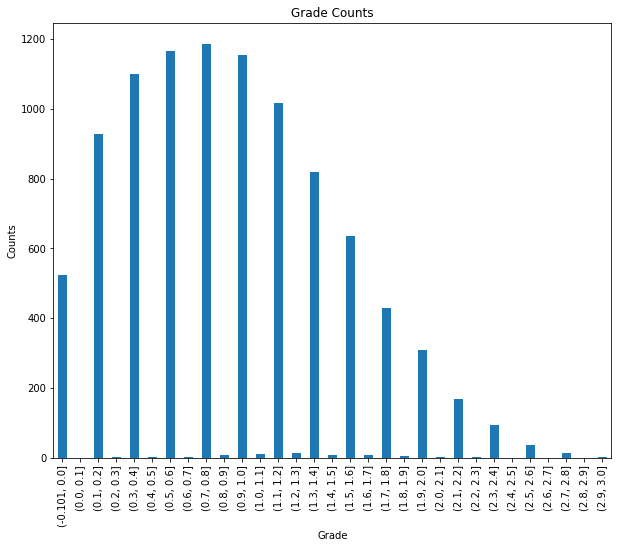

In [163]:
print("Mean grade: {}".format(grades.mean()))
bins = np.arange(-0.1, 3.1, 0.1)
print("bins: {}".format(bins))

grade_counts = grades.value_counts(bins=bins, sort=False)
grade_counts.plot(figsize=(10,8), title="Grade Counts", kind="bar", xlabel="Grade", ylabel="Counts")

### Word/character count/length distribution

In [212]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))


# Get average word length of edited sentence.
train_df['avgWordLength'] = train_df['editedSentence'].apply(lambda x: avg_word(x))
train_df.head()

,id,original,edit,grades,meanGrade,editedSentence,replaceWord,avgWordLength,gradeCategory,wordCounts,charCounts,numStopWords
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,France is ‘ hunting down its citizens who join...,Isis,4.266667,<0.5,15,78,5
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian tr...",Syria,4.705882,<2.0,17,96,4
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor ...,Coalition,5.000000,<1.5,11,60,1
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,"In an apparent first , Iran and Israel slap ea...",engage,4.500000,<0.5,12,65,4
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,Trump was told weeks ago that Flynn misled sch...,Vice,4.636364,<0.5,11,61,2


In [211]:
new_bins = np.arange(-0.1, 3, 0.5)
print("New Bins: {}".format(new_bins))
train_df['gradeCategory'] = pd.cut(train_df['meanGrade'], bins=new_bins, labels=["<0.5", "<1.0", "<1.5", "<2.0", "<2.5", "<3.0"])
train_df.head()

New Bins: [-0.1  0.4  0.9  1.4  1.9  2.4  2.9]


,id,original,edit,grades,meanGrade,editedSentence,replaceWord,avgWordLength,gradeCategory,wordCounts,charCounts,numStopWords
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,France is ‘ hunting down its citizens who join...,Isis,4.266667,<0.5,15,78,5
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian tr...",Syria,4.705882,<2.0,17,96,4
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor ...,Coalition,5.000000,<1.5,11,60,1
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,"In an apparent first , Iran and Israel slap ea...",engage,4.500000,<0.5,12,65,4
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,Trump was told weeks ago that Flynn misled sch...,Vice,4.636364,<0.5,11,61,2


In [182]:
train_df.groupby(['gradeCategory']).mean()

,id,grades,meanGrade,avgWordLength
gradeCategory,,,,
<0.5,7592.063846,6.261905e+06,0.245280,4.997989
<1.0,7529.421453,1.360546e+11,0.701168,4.956630
<1.5,7535.619032,2.170480e+11,1.177829,4.921622
<2.0,7381.708756,3.071965e+11,1.680584,4.847710
<2.5,7685.178819,1.157486e+12,2.125174,4.861186
<3.0,7586.538462,1.282371e+08,2.648077,4.518674


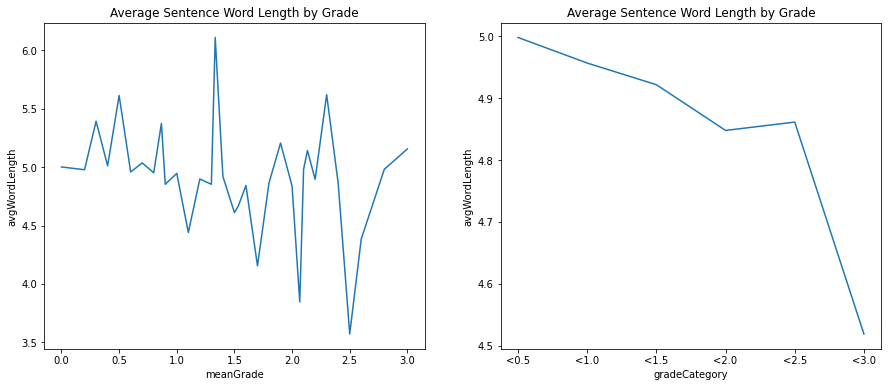

In [192]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

train_df.groupby(['meanGrade']).mean()['avgWordLength'].plot(title="Average Sentence Word Length by Grade", ylabel="avgWordLength", ax=axes[0])
train_df.groupby(['gradeCategory']).mean()['avgWordLength'].plot(title="Average Sentence Word Length by Grade", ylabel="avgWordLength", ax=axes[1])

In [209]:
train_df['wordCounts'] = train_df['editedSentence'].apply(lambda x: len(str(x).split(" ")))
train_df.head()

,id,original,edit,grades,meanGrade,editedSentence,replaceWord,avgWordLength,gradeCategory,wordCounts,charCounts,numStopWords
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,France is ‘ hunting down its citizens who join...,Isis,4.266667,<0.5,15,78,5
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian tr...",Syria,4.705882,<2.0,17,96,4
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor ...,Coalition,5.000000,<1.5,11,60,1
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,"In an apparent first , Iran and Israel slap ea...",engage,4.500000,<0.5,12,65,4
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,Trump was told weeks ago that Flynn misled sch...,Vice,4.636364,<0.5,11,61,2


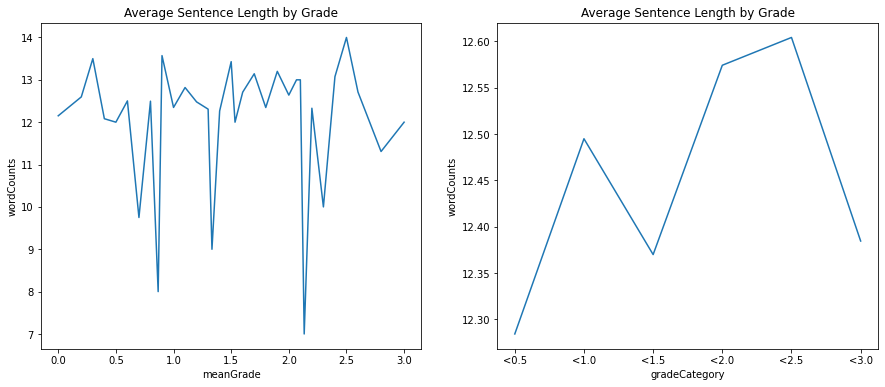

In [197]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

train_df.groupby(['meanGrade']).mean()['wordCounts'].plot(title="Average Sentence Length by Grade", ylabel="wordCounts", ax=axes[0])
train_df.groupby(['gradeCategory']).mean()['wordCounts'].plot(title="Average Sentence Length by Grade", ylabel="wordCounts", ax=axes[1])

In [208]:
train_df['charCounts'] = train_df['editedSentence'].str.len()  # This also includes spaces.
train_df.head()

,id,original,edit,grades,meanGrade,editedSentence,replaceWord,avgWordLength,gradeCategory,wordCounts,charCounts,numStopWords
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,France is ‘ hunting down its citizens who join...,Isis,4.266667,<0.5,15,78,5
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian tr...",Syria,4.705882,<2.0,17,96,4
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor ...,Coalition,5.000000,<1.5,11,60,1
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,"In an apparent first , Iran and Israel slap ea...",engage,4.500000,<0.5,12,65,4
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,Trump was told weeks ago that Flynn misled sch...,Vice,4.636364,<0.5,11,61,2


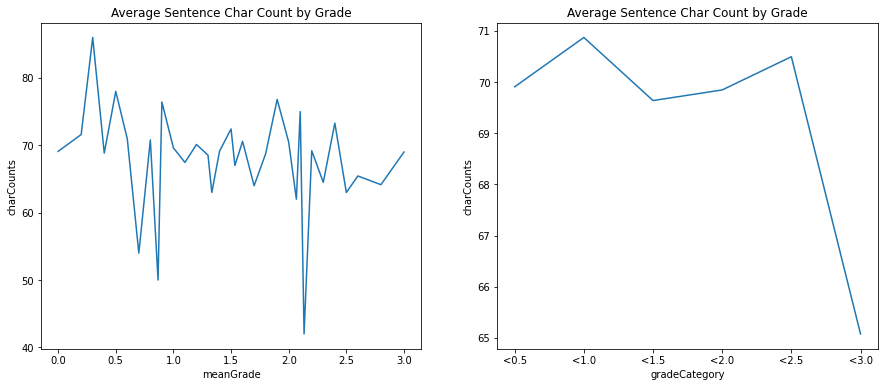

In [199]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

train_df.groupby(['meanGrade']).mean()['charCounts'].plot(title="Average Sentence Char Count by Grade", ylabel="charCounts", ax=axes[0])
train_df.groupby(['gradeCategory']).mean()['charCounts'].plot(title="Average Sentence Char Count by Grade", ylabel="charCounts", ax=axes[1])

### Stop word analysis

In [202]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [207]:
train_df['numStopWords'] = train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x in stop]))
train_df.head()

,id,original,edit,grades,meanGrade,editedSentence,replaceWord,avgWordLength,gradeCategory,wordCounts,charCounts,numStopWords
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,France is ‘ hunting down its citizens who join...,Isis,4.266667,<0.5,15,78,5
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian tr...",Syria,4.705882,<2.0,17,96,4
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor ...,Coalition,5.000000,<1.5,11,60,1
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,"In an apparent first , Iran and Israel slap ea...",engage,4.500000,<0.5,12,65,4
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,Trump was told weeks ago that Flynn misled sch...,Vice,4.636364,<0.5,11,61,2


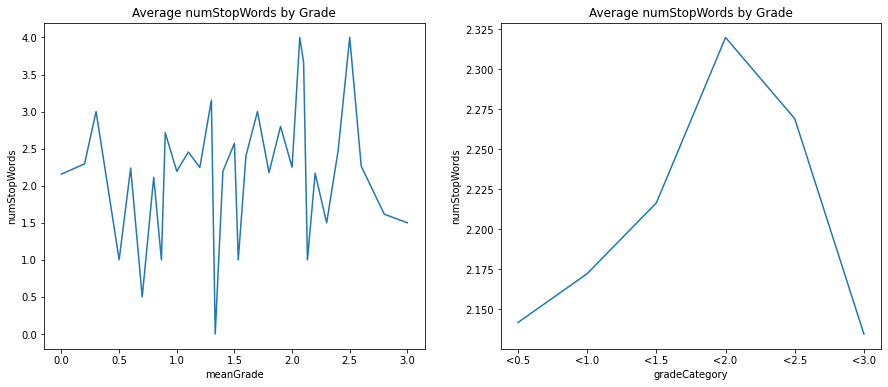

In [206]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

train_df.groupby(['meanGrade']).mean()['numStopWords'].plot(title="Average numStopWords by Grade", ylabel="numStopWords", ax=axes[0])
train_df.groupby(['gradeCategory']).mean()['numStopWords'].plot(title="Average numStopWords by Grade", ylabel="numStopWords", ax=axes[1])

### Special characters

In [223]:
# Number of sentences with hashtags.
train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x.startswith('#')])).value_counts()
train_df['numHashtags'] = train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

In [224]:
# Number of sentences with digits.
train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x.isdigit()])).value_counts()
train_df['numDigits'] = train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

In [225]:
# Number of upper case words.
train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x.isupper()])).value_counts()
train_df['numUpperCase'] = train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

In [226]:
train_df.head()

,id,original,edit,grades,meanGrade,editedSentence,replaceWord,avgWordLength,gradeCategory,wordCounts,charCounts,numStopWords,numHashtags,numDigits,numUpperCase
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,France is ‘ hunting down its citizens who join...,Isis,4.266667,<0.5,15,78,5,0,0,0
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian tr...",Syria,4.705882,<2.0,17,96,4,0,0,0
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor ...,Coalition,5.000000,<1.5,11,60,1,0,0,1
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,"In an apparent first , Iran and Israel slap ea...",engage,4.500000,<0.5,12,65,4,0,0,0
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,Trump was told weeks ago that Flynn misled sch...,Vice,4.636364,<0.5,11,61,2,0,0,0


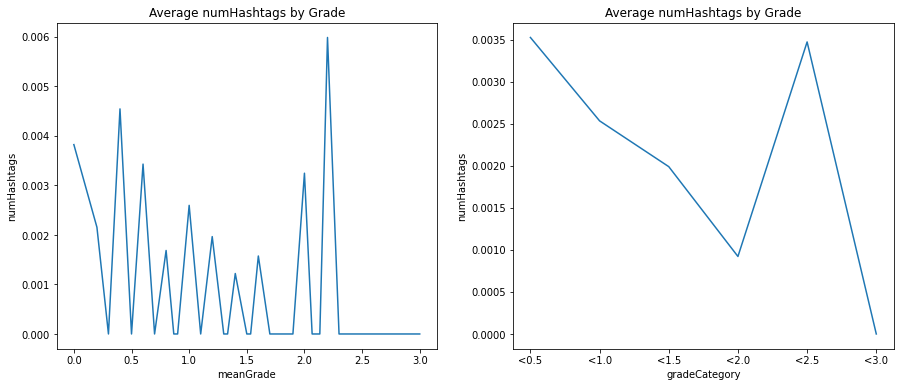

In [227]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

train_df.groupby(['meanGrade']).mean()['numHashtags'].plot(title="Average numHashtags by Grade", ylabel="numHashtags", ax=axes[0])
train_df.groupby(['gradeCategory']).mean()['numHashtags'].plot(title="Average numHashtags by Grade", ylabel="numHashtags", ax=axes[1])

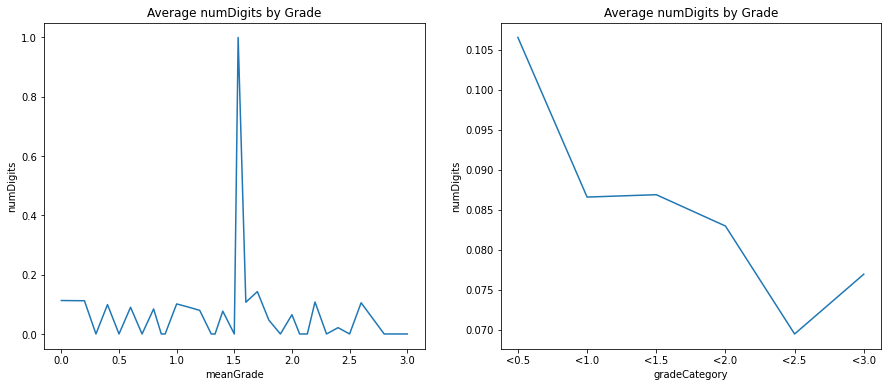

In [228]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

train_df.groupby(['meanGrade']).mean()['numDigits'].plot(title="Average numDigits by Grade", ylabel="numDigits", ax=axes[0])
train_df.groupby(['gradeCategory']).mean()['numDigits'].plot(title="Average numDigits by Grade", ylabel="numDigits", ax=axes[1])

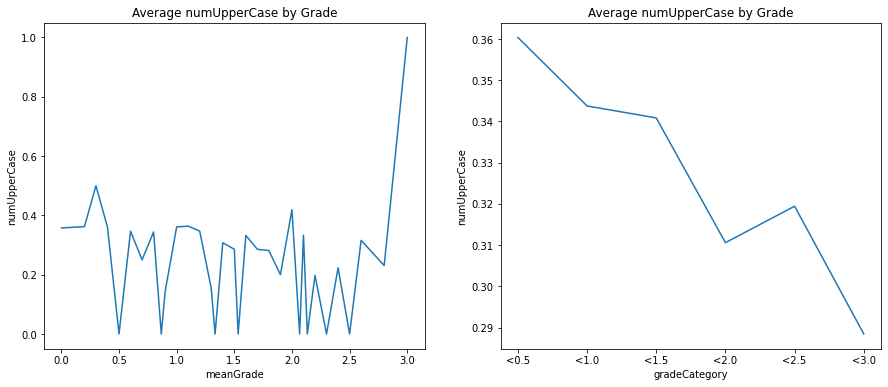

In [229]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

train_df.groupby(['meanGrade']).mean()['numUpperCase'].plot(title="Average numUpperCase by Grade", ylabel="numUpperCase", ax=axes[0])
train_df.groupby(['gradeCategory']).mean()['numUpperCase'].plot(title="Average numUpperCase by Grade", ylabel="numUpperCase", ax=axes[1])

## Text preprocessing

### Lower casing

In [250]:
# Create new dataframe.
# Convert all to lowercase.
processed = pd.DataFrame(train_df['editedSentence'].apply(lambda x: " ".join(x.lower() for x in x.split())))
processed['original'] = train_df['original'].apply(lambda x: " ".join(x.lower() for x in x.split()))
processed.head()

,editedSentence,original
0,france is ‘ hunting down its citizens who join...,france is ‘ hunting down its citizens who join...
1,"pentagon claims 2,000 % increase in russian tr...","pentagon claims 2,000 % increase in russian tr..."
2,iceland pm calls snap vote as pedophile furor ...,iceland pm calls snap vote as pedophile furor ...
3,"in an apparent first , iran and israel slap ea...","in an apparent first , iran and israel <engage..."
4,trump was told weeks ago that flynn misled sch...,trump was told weeks ago that flynn misled <vi...


### Remove punctuation

In [251]:
# Remove punctuation.
processed['editedSentence'] = processed['editedSentence'].str.replace('[^\w\s]','')
processed['original'] = processed['original'].str.replace('[^\w\s]','')
processed.head()

,editedSentence,original
0,france is hunting down its citizens who joine...,france is hunting down its citizens who joine...
1,pentagon claims 2000 increase in russian trol...,pentagon claims 2000 increase in russian trol...
2,iceland pm calls snap vote as pedophile furor ...,iceland pm calls snap vote as pedophile furor ...
3,in an apparent first iran and israel slap eac...,in an apparent first iran and israel engage e...
4,trump was told weeks ago that flynn misled sch...,trump was told weeks ago that flynn misled vic...


### Remove stop words

In [252]:
# Remove stop words.
processed['editedSentence'] = processed['editedSentence'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
processed['original'] = processed['original'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
processed.head()

,editedSentence,original
0,france hunting citizens joined twins without t...,france hunting citizens joined isis without tr...
1,pentagon claims 2000 increase russian trolls b...,pentagon claims 2000 increase russian trolls s...
2,iceland pm calls snap vote pedophile furor cra...,iceland pm calls snap vote pedophile furor cra...
3,apparent first iran israel slap militarily,apparent first iran israel engage militarily
4,trump told weeks ago flynn misled school presi...,trump told weeks ago flynn misled vice president


### Word frequencies

In [256]:
# Get set of replacement words.
replacement_words = train_df['edit']
replacement_words

0              twins
1            bowling
2              party
3               slap
4             school
            ...     
9647            idea
9648    stewardesses
9649          raisin
9650            cake
9651            food
Name: edit, Length: 9652, dtype: object

In [262]:
# Find common words.
freq = pd.Series(' '.join(processed['editedSentence']).split()).value_counts()
top_freq = freq[:10]
top_freq

trump     3345
us         758
says       621
house      502
new        367
nt         367
donald     359
white      348
gop        295
russia     292
dtype: int64

In [263]:
# Find rare words.
bottom_freq = freq[-10:]
bottom_freq

skyscraper    1
assist        1
showgirl      1
sweeteners    1
shelters      1
emus          1
sacrifices    1
canoe         1
saunas        1
delights      1
dtype: int64

In [275]:
# We cannot delete the most/least common words because they are the edited words.
print("Least common words that are replacement words: {}".format(set.intersection(set(bottom_freq.index.tolist()), set(replacement_words.values.tolist()))))
print("Most common words that are replacement words: {}".format(set.intersection(set(top_freq.index.tolist()), set(replacement_words.values.tolist()))))

Least common words that are replacement words: {'delights', 'shelters', 'sacrifices', 'canoe', 'saunas', 'emus', 'showgirl', 'sweeteners'}
Most common words that are replacement words: {'house', 'trump'}


### Lemmatization

In [293]:
from textblob import Word, TextBlob
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [282]:
processed['editedSentence'] = processed['editedSentence'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
processed['original'] = processed['original'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
processed.head()

,editedSentence,original
0,france hunting citizen joined twin without tri...,france hunting citizen joined isi without tria...
1,pentagon claim 2000 increase russian troll bow...,pentagon claim 2000 increase russian troll syr...
2,iceland pm call snap vote pedophile furor cras...,iceland pm call snap vote pedophile furor cras...
3,apparent first iran israel slap militarily,apparent first iran israel engage militarily
4,trump told week ago flynn misled school president,trump told week ago flynn misled vice president


## Feature extraction

In [283]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer

### TD-IDF

In [417]:
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(processed['editedSentence'])
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)
train_counts

<9652x8977 sparse matrix of type '<class 'numpy.float64'>'
	with 72252 stored elements in Compressed Sparse Row format>

### BOW

In [418]:
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(processed['editedSentence'])
train_bow

<9652x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 44922 stored elements in Compressed Sparse Row format>

### Sentiment

In [297]:
processed['sentiment'] = processed['editedSentence'].apply(lambda x: TextBlob(x).sentiment[0])
processed['sentimentOrig'] = processed['original'].apply(lambda x: TextBlob(x).sentiment[0])
processed

,editedSentence,original,sentiment,sentimentOrig
0,france hunting citizen joined twin without tri...,france hunting citizen joined isi without tria...,0.000000,0.000000
1,pentagon claim 2000 increase russian troll bow...,pentagon claim 2000 increase russian troll syr...,-0.156250,-0.156250
2,iceland pm call snap vote pedophile furor cras...,iceland pm call snap vote pedophile furor cras...,0.000000,0.000000
3,apparent first iran israel slap militarily,apparent first iran israel engage militarily,0.066667,0.066667
4,trump told week ago flynn misled school president,trump told week ago flynn misled vice president,0.000000,0.000000
...,...,...,...,...
9647,state official blast unprecedented dhs idea se...,state official blast unprecedented dhs move se...,0.500000,0.500000
9648,protester rally stewardess detained jfk airpor...,protester rally refugee detained jfk airport t...,0.000000,0.000000
9649,cruise line carnival corp join fight bermuda s...,cruise line carnival corp join fight bermuda s...,0.000000,0.000000
9650,columbia police hunt woman seen cake near univ...,columbia police hunt woman seen gun near unive...,0.100000,0.100000


In [300]:
processed['sentimentDiff'] = processed['sentiment'] - processed['sentimentOrig']
processed

,editedSentence,original,sentiment,sentimentOrig,sentimentDiff
0,france hunting citizen joined twin without tri...,france hunting citizen joined isi without tria...,0.000000,0.000000,0.0
1,pentagon claim 2000 increase russian troll bow...,pentagon claim 2000 increase russian troll syr...,-0.156250,-0.156250,0.0
2,iceland pm call snap vote pedophile furor cras...,iceland pm call snap vote pedophile furor cras...,0.000000,0.000000,0.0
3,apparent first iran israel slap militarily,apparent first iran israel engage militarily,0.066667,0.066667,0.0
4,trump told week ago flynn misled school president,trump told week ago flynn misled vice president,0.000000,0.000000,0.0
...,...,...,...,...,...
9647,state official blast unprecedented dhs idea se...,state official blast unprecedented dhs move se...,0.500000,0.500000,0.0
9648,protester rally stewardess detained jfk airpor...,protester rally refugee detained jfk airport t...,0.000000,0.000000,0.0
9649,cruise line carnival corp join fight bermuda s...,cruise line carnival corp join fight bermuda s...,0.000000,0.000000,0.0
9650,columbia police hunt woman seen cake near univ...,columbia police hunt woman seen gun near unive...,0.100000,0.100000,0.0


In [312]:
# Combine dataframes
data = pd.concat([train_df, processed], axis=1)
data

,id,original,edit,grades,meanGrade,editedSentence,replaceWord,avgWordLength,gradeCategory,wordCounts,charCounts,numStopWords,numHashtags,numDigits,numUpperCase,editedSentence,original,sentiment,sentimentOrig,sentimentDiff
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,France is ‘ hunting down its citizens who join...,Isis,4.266667,<0.5,15,78,5,0,0,0,france hunting citizen joined twin without tri...,france hunting citizen joined isi without tria...,0.000000,0.000000,0.0
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian tr...",Syria,4.705882,<2.0,17,96,4,0,0,0,pentagon claim 2000 increase russian troll bow...,pentagon claim 2000 increase russian troll syr...,-0.156250,-0.156250,0.0
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor ...,Coalition,5.000000,<1.5,11,60,1,0,0,1,iceland pm call snap vote pedophile furor cras...,iceland pm call snap vote pedophile furor cras...,0.000000,0.000000,0.0
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,"In an apparent first , Iran and Israel slap ea...",engage,4.500000,<0.5,12,65,4,0,0,0,apparent first iran israel slap militarily,apparent first iran israel engage militarily,0.066667,0.066667,0.0
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,Trump was told weeks ago that Flynn misled sch...,Vice,4.636364,<0.5,11,61,2,0,0,0,trump told week ago flynn misled school president,trump told week ago flynn misled vice president,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9647,10899,State officials blast ' unprecedented ' DHS <m...,idea,0,0.0,State officials blast ' unprecedented ' DHS id...,move,5.333333,<0.5,12,75,1,0,0,1,state official blast unprecedented dhs idea se...,state official blast unprecedented dhs move se...,0.500000,0.500000,0.0
9648,1781,Protesters Rally for <Refugees/> Detained at J...,stewardesses,20000,0.4,Protesters Rally for stewardesses Detained at ...,Refugees,5.727273,<0.5,11,73,2,0,0,1,protester rally stewardess detained jfk airpor...,protester rally refugee detained jfk airport t...,0.000000,0.000000,0.0
9649,5628,Cruise line Carnival Corp. joins the fight aga...,raisin,21000,0.6,Cruise line Carnival Corp. joins the fight aga...,marriage,5.307692,<1.0,13,81,2,0,0,0,cruise line carnival corp join fight bermuda s...,cruise line carnival corp join fight bermuda s...,0.000000,0.000000,0.0
9650,14483,Columbia police hunt woman seen with <gun/> ne...,cake,32200,1.4,Columbia police hunt woman seen with cake near...,gun,5.416667,<1.5,12,76,2,0,0,0,columbia police hunt woman seen cake near univ...,columbia police hunt woman seen gun near unive...,0.100000,0.100000,0.0


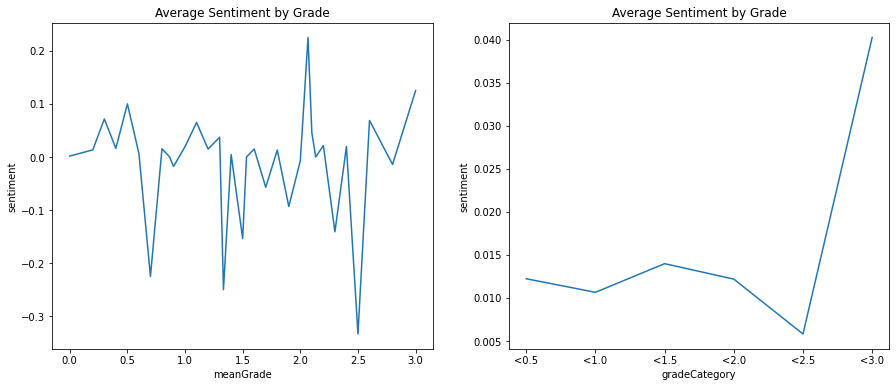

In [313]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

data.groupby(['meanGrade']).mean()['sentiment'].plot(title="Average Sentiment by Grade", ylabel="sentiment", ax=axes[0])
data.groupby(['gradeCategory']).mean()['sentiment'].plot(title="Average Sentiment by Grade", ylabel="sentiment", ax=axes[1])

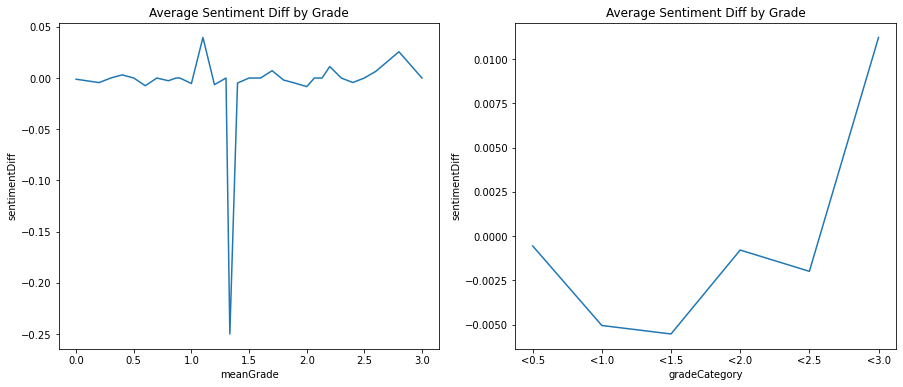

In [314]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

data.groupby(['meanGrade']).mean()['sentimentDiff'].plot(title="Average Sentiment Diff by Grade", ylabel="sentimentDiff", ax=axes[0])
data.groupby(['gradeCategory']).mean()['sentimentDiff'].plot(title="Average Sentiment Diff by Grade", ylabel="sentimentDiff", ax=axes[1])

### Extract numeric features

In [318]:
numeric_data = data.select_dtypes(['number']).drop(columns='id')
numeric_data

,grades,meanGrade,avgWordLength,wordCounts,charCounts,numStopWords,numHashtags,numDigits,numUpperCase,sentiment,sentimentOrig,sentimentDiff
0,10000,0.2,4.266667,15,78,5,0,0,0,0.000000,0.000000,0.0
1,33110,1.6,4.705882,17,96,4,0,0,0,-0.156250,-0.156250,0.0
2,22100,1.0,5.000000,11,60,1,0,0,1,0.000000,0.000000,0.0
3,20000,0.4,4.500000,12,65,4,0,0,0,0.066667,0.066667,0.0
4,0,0.0,4.636364,11,61,2,0,0,0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9647,0,0.0,5.333333,12,75,1,0,0,1,0.500000,0.500000,0.0
9648,20000,0.4,5.727273,11,73,2,0,0,1,0.000000,0.000000,0.0
9649,21000,0.6,5.307692,13,81,2,0,0,0,0.000000,0.000000,0.0
9650,32200,1.4,5.416667,12,76,2,0,0,0,0.100000,0.100000,0.0


## Train 

In [319]:
from torch.utils.data import Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [362]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

In [327]:
train_proportion = 0.8

In [383]:
def train_and_test(x, y):
  training_data, dev_data, training_y, dev_y = train_test_split(x, y, test_size=(1-train_proportion),
                                                                          random_state=42)

  regression_model = DecisionTreeRegressor().fit(training_data, training_y)
  predicted_train = regression_model.predict(training_data)
  predicted_dev = regression_model.predict(dev_data)

  print("\nTrain performance:")
  sse, mse = model_performance(predicted_train, training_y, True)
  print("\nDev performance:")
  sse, mse = model_performance(predicted_dev, dev_y, True)

In [430]:
# Extract features.
x_df = numeric_data.drop(columns=['meanGrade', 'grades'])
x = x_df.values
y = numeric_data['meanGrade'].values
print("x shape: {}, y shape: {}".format(x.shape, y.shape))

x shape: (9652, 10), y shape: (9652,)


In [431]:
print("Features: {}".format(x_df.columns))
train_and_test(x, y)

Features: Index(['avgWordLength', 'wordCounts', 'charCounts', 'numStopWords',
       'numHashtags', 'numDigits', 'numUpperCase', 'sentiment',
       'sentimentOrig', 'sentimentDiff'],
      dtype='object')

Train performance:
| MSE: 0.06 | RMSE: 0.25 |

Dev performance:
| MSE: 0.64 | RMSE: 0.80 |


In [432]:
for column in x_df.columns:
  new_data = x_df.drop(columns=column)
  x = new_data.values
  print("Features: {}".format(new_data.columns))
  train_and_test(x, y)

Features: Index(['wordCounts', 'charCounts', 'numStopWords', 'numHashtags', 'numDigits',
       'numUpperCase', 'sentiment', 'sentimentOrig', 'sentimentDiff'],
      dtype='object')

Train performance:
| MSE: 0.08 | RMSE: 0.29 |

Dev performance:
| MSE: 0.61 | RMSE: 0.78 |
Features: Index(['avgWordLength', 'charCounts', 'numStopWords', 'numHashtags',
       'numDigits', 'numUpperCase', 'sentiment', 'sentimentOrig',
       'sentimentDiff'],
      dtype='object')

Train performance:
| MSE: 0.06 | RMSE: 0.25 |

Dev performance:
| MSE: 0.65 | RMSE: 0.80 |
Features: Index(['avgWordLength', 'wordCounts', 'numStopWords', 'numHashtags',
       'numDigits', 'numUpperCase', 'sentiment', 'sentimentOrig',
       'sentimentDiff'],
      dtype='object')

Train performance:
| MSE: 0.06 | RMSE: 0.25 |

Dev performance:
| MSE: 0.62 | RMSE: 0.79 |
Features: Index(['avgWordLength', 'wordCounts', 'charCounts', 'numHashtags', 'numDigits',
       'numUpperCase', 'sentiment', 'sentimentOrig', 'sentimentDiff'

In [433]:
new_data = np.expand_dims(x_df['sentimentDiff'], axis=1)
train_and_test(new_data, y)


Train performance:
| MSE: 0.33 | RMSE: 0.58 |

Dev performance:
| MSE: 0.35 | RMSE: 0.59 |


In [434]:
x_tdif = np.concatenate((x, train_counts.toarray(), train_bow.toarray()), axis=1)
x_tdif.shape

(9652, 9986)

In [ ]:
train_and_test(x_tdif, y)